# Entrenamiento inicial de nuestro modelo
En este notebook estará un modelo muy muy sencillo para empezar a practicar y detectar drift muy simple, se usará un modelo de clasificación de 2 variables, el modelo o proceso que define el evento "real" es:

$$
y = \begin{cases}
        1 & \text{if } x_2 > sx_1 \\
        0 & \text{otherwise}
    \end{cases}
$$

donde la variable $s$ representa la pendiente, donde por default diremos que es $-1$, por tanto creemos nuestros datos.

In [1]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.stats import multivariate_normal

In [2]:
# Modelo/proceso verdero (ground true)
def true_model(X,slope=-1):
    z = slope*X[:,0]
    idx = np.argwhere(X[:,1]>z)
    y = np.zeros(X.shape[0])
    y[idx] = 1
    return y

true_slope = -1

Tomemos la distribución de referencia como una mezcla de dos distribuciones normales, solo para fines educativos.
$$
    P_{ref}(\mathbf{X}) = \phi_1\mathcal{N}\left(\left[-1,-1\right]^T, \sigma^2\mathbf{I} \right) + \phi\mathcal{N}\left(\left[-1,-1\right]^T, \sigma^2\mathbf{I} \right)
$$

con una desviación estándar de $\sigma=0.8$ y los pesos de $\phi_1 = \phi_2 = 0.5$. Los datos de referencia $\mathbf{X}^{ref}$ y los datos de entrenamiento $\mathbf{X}^{train}$ serán generados a partir de esta distribución de referencia. Y los labels $y^{ref}$, $y^{train}$ pueden igualmente ser obtenidos al evaluar el ```true_model()``` sobre los respectivos datos.

In [3]:
# Distribución de referencia
sigma = 0.8
phi1 = 0.5
phi2 = 0.5
ref_norm_0 = multivariate_normal([-1,-1], np.eye(2)*sigma**2)
ref_norm_1 = multivariate_normal([ 1, 1], np.eye(2)*sigma**2)

# Reference data
N_ref = 240
X_0 = ref_norm_0.rvs(size=int(N_ref*phi1),random_state=1)
X_1 = ref_norm_1.rvs(size=int(N_ref*phi2),random_state=1)
X_ref = np.vstack([X_0, X_1])
y_ref = true_model(X_ref,true_slope)

# Training data
N_train = 240
X_0 = ref_norm_0.rvs(size=int(N_train*phi1),random_state=0)
X_1 = ref_norm_1.rvs(size=int(N_train*phi2),random_state=0)
X_train = np.vstack([X_0, X_1])
y_train = true_model(X_train,true_slope)

In [4]:
# Función para plotear para ahorrar tiempo:
plt.rcParams.update({'font.size': 16})

def plot(X,y, slope, clf=None):
    # Init plot
    fig, ax = plt.subplots(figsize=(4,4))
    #ax.axis('equal')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_xlim([-3.5,3.5])
    ax.set_ylim([-6,3.3])
    
    # Plot data
    cmap = LinearSegmentedColormap.from_list('my_cmap', [(0.78,0.44,0.22), (0.22, 0.44, 0.78)], N=2)
    scat = ax.scatter(X[:,0], X[:,1],c=y,ec='k',s=70,cmap=cmap,alpha=0.7)
    
    # Plot true decision boundary
    xconcept = np.array(ax.get_xlim())
    ax.plot(xconcept,xconcept*slope,'k--',lw=2,alpha=0.8)
    
    if clf is not None:
        # Plot classifier decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xx = np.linspace(xlim[0], xlim[1], 100)
        yy = np.linspace(ylim[0], ylim[1], 100)
        XX, YY = np.meshgrid(xx, yy)
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3, levels=1)
        ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=[2,0], levels=1,alpha=0.8)

    plt.show()
    
labels = ['No','Yes']

Para el modelo, elegimos el conocido clasificador de árboles de decisión.

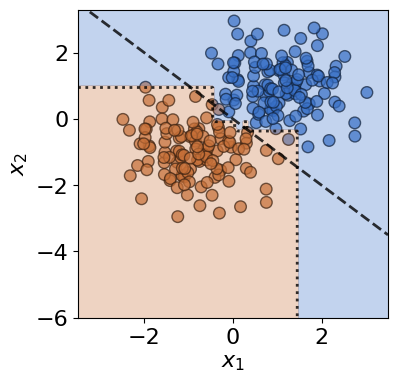

Mean training accuracy 99.17


In [46]:
# Desision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=20)
clf.fit(X_train, y_train)

# Plotear
plot(X_ref,y_ref,true_slope,clf=clf)

# Accuracy del modelo
print(f'Mean training accuracy {100*clf.score(X_ref,y_ref):.2f}')

##### Ahora detectemos el Drift de la data procesada

In [9]:
import pandas as pd
import json

In [8]:
df = pd.read_csv("logs.csv")
df.head()

,@timestamp,@version,context,data_stream.dataset,type,response,request,path,metrics,method,...,level,latency,host,extra_data,data_stream.type,data_stream.namespace,event.original,_id,_index,_score
0,"Aug 20, 2024 @ 01:02:10.114",1,NaN,generic,logstash,"{""message"":""Prediction successful"",""input_data...","{""x1"": 3.040350588703728, ""x2"": -0.17853859823...",/home/bubu/CF-classes/CodigoFacilito-Drift-Det...,-,POST,...,INFO,0.001,DESKTOP-7CGFAPL,-,logs,default,"{""@timestamp"": ""2024-08-20T07:02:10.114Z"", ""@v...",t0CXbpEBFxHMiGpb1i-n,.ds-logs-generic-default-2024.08.20-000001,0.025
1,"Aug 20, 2024 @ 01:02:10.112",1,NaN,generic,logstash,"{""message"":""Prediction successful"",""input_data...","{""x1"": 0.441128040050889, ""x2"": 0.256886460380...",/home/bubu/CF-classes/CodigoFacilito-Drift-Det...,-,POST,...,INFO,0.000,DESKTOP-7CGFAPL,-,logs,default,"{""@timestamp"": ""2024-08-20T07:02:10.112Z"", ""@v...",30CXbpEBFxHMiGpb1i_I,.ds-logs-generic-default-2024.08.20-000001,0.025
2,"Aug 20, 2024 @ 01:02:10.111",1,NaN,generic,logstash,"{""message"":""Prediction successful"",""input_data...","{""x1"": 0.7790564061994097, ""x2"": 0.58649288501...",/home/bubu/CF-classes/CodigoFacilito-Drift-Det...,-,POST,...,INFO,0.000,DESKTOP-7CGFAPL,-,logs,default,"{""@timestamp"": ""2024-08-20T07:02:10.111Z"", ""@v...",F0CXbpEBFxHMiGpb1i-V,.ds-logs-generic-default-2024.08.20-000001,0.025
3,"Aug 20, 2024 @ 01:02:10.109",1,NaN,generic,logstash,"{""message"":""Prediction successful"",""input_data...","{""x1"": 0.2782031455435985, ""x2"": 0.52722217962...",/home/bubu/CF-classes/CodigoFacilito-Drift-Det...,-,POST,...,INFO,0.001,DESKTOP-7CGFAPL,-,logs,default,"{""@timestamp"": ""2024-08-20T07:02:10.109Z"", ""@v...",80CXbpEBFxHMiGpb1i_M,.ds-logs-generic-default-2024.08.20-000001,0.025
4,"Aug 20, 2024 @ 01:02:10.107",1,NaN,generic,logstash,"{""message"":""Prediction successful"",""input_data...","{""x1"": 0.7399602972945711, ""x2"": 0.55181239500...",/home/bubu/CF-classes/CodigoFacilito-Drift-Det...,-,POST,...,INFO,0.001,DESKTOP-7CGFAPL,-,logs,default,"{""@timestamp"": ""2024-08-20T07:02:10.107Z"", ""@v...",K0CXbpEBFxHMiGpb1i-W,.ds-logs-generic-default-2024.08.20-000001,0.025


In [10]:
# Check if the Accuracy is okay
response = df["response"]
response_dicts = response.apply(json.loads)
response_list = response_dicts.tolist()
response_list[:3]

[{'message': 'Prediction successful',
  'input_data': {'x1': 3.040350588703728,
   'x2': -0.17853859823990859,
   'tag': 'test_drift'},
  'prediction': [1.0]},
 {'message': 'Prediction successful',
  'input_data': {'x1': 0.441128040050889,
   'x2': 0.25688646038094465,
   'tag': 'test_drift'},
  'prediction': [1.0]},
 {'message': 'Prediction successful',
  'input_data': {'x1': 0.7790564061994097,
   'x2': 0.5864928850139306,
   'tag': 'test_drift'},
  'prediction': [1.0]}]

In [33]:
X_no_drift = np.array([[d["input_data"]["x1"], d["input_data"]["x2"]] for d in response_list if "input_data" in d and "tag" in d["input_data"] and d["input_data"]["tag"] == "test_no_drift"] )
y_no_drift = np.array([d["prediction"][0] for d in response_list if "input_data" in d and "tag" in d["input_data"] and d["input_data"]["tag"] == "test_no_drift"])
X_drift = np.array([[d["input_data"]["x1"], d["input_data"]["x2"]] for d in response_list if "input_data" in d and "tag" in d["input_data"] and d["input_data"]["tag"] == "test_drift"] )
y_drift = np.array([d["prediction"][0] for d in response_list if "input_data" in d and "tag" in d["input_data"] and d["input_data"]["tag"] == "test_drift"])
print(X_pred[:3])
print(y_pred[:3])

[[ 3.04035059 -0.1785386 ]
 [ 0.44112804  0.25688646]
 [ 0.77905641  0.58649289]]
[1. 1. 1.]


In [41]:
unique, counts = np.unique(y_no_drift, return_counts=True)
dict(zip(unique, counts))

{0.0: 61, 1.0: 59}

In [40]:
unique, counts = np.unique(y_drift, return_counts=True)
dict(zip(unique, counts))

{0.0: 24, 1.0: 96}

## No drift

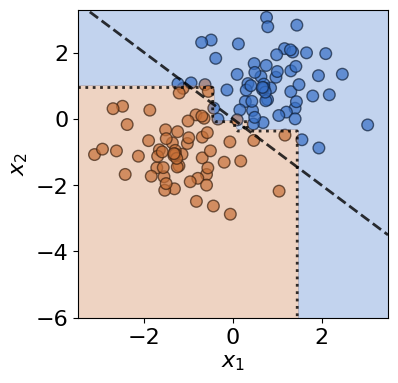

Mean test accuracy 95.00


In [54]:
plot(X_no_drift, y_no_drift, true_slope, clf = clf)
# Accuracy del X_drift!
y_test = true_model(X_no_drift)
print(f'Mean test accuracy {100*clf.score(X_no_drift,y_test):.2f}')

## Sí Drift

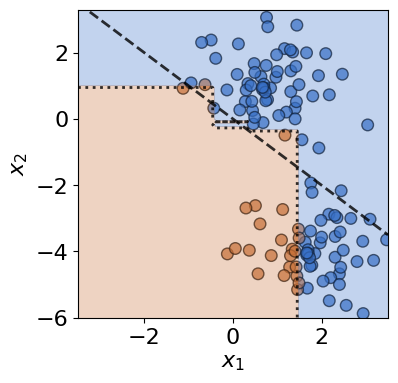

In [42]:
plot(X_drift,y_drift,true_slope,clf=clf)

In [50]:
# Accuracy del X_drift!
y_test = true_model(X_drift)
print(f'Mean test accuracy {100*clf.score(X_drift,y_test):.2f}')

Mean test accuracy 66.67
